## Project Info 

* This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

* Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

* RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

* The goal of this analysis is to identify customer segments for global retail company using RFM analysis and to understand how those groups differ from each other.

# Data Preperation 

## Import libraries

In [1]:
import pandas as pd
import numpy as np 
import time
import datetime as dt

import re

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import collections
from collections import Counter
from collections import defaultdict
import itertools

from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

start = time.time()

In [2]:
df = pd.read_csv('rfm_data.csv', encoding = 'unicode_escape', dtype = {'CustomerID' : str})

# The first five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
# The last five rows 

df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/2011 12:50,4.95,12680,France


# Data Explorations:

### Columns Description :

* InvoiceNo : Unique ID for every time a consumer visits the store
* StockCode: Unique ID for a product
* Description : Description of the product
* Quantity : No of units bought
*InvoiceDate : Date and time of purchase
*Unit Price : Price for 1 unit of the product
*CustomerId : Unique ID for each customer
*Country : Country where transaction happened


* Also for our analysis we need to calculate the total sales for each product by multiplying Quantity with Unit Price. Also, convert Invoice Date in YYYYMM format.

### Let's understand the columns names first, before we move on 

In [4]:
print('The name of each column are below: \n')

i = 0 
for column_name in df.columns:
    i += 1
    print(f'{i}.', column_name)

The name of each column are below: 

1. InvoiceNo
2. StockCode
3. Description
4. Quantity
5. InvoiceDate
6. UnitPrice
7. CustomerID
8. Country


In [5]:
# I will change the names or the first letters of some columns in order to make it easy as i type

df.rename(index = str , 
          columns = {'InvoiceNo': 'invoice_num',
                    'StockCode' : 'stock_code',
                    'Description' : 'description',
                    'Quantity' : 'quantity',
                    'InvoiceDate' : 'invoice_date',
                    'UnitPrice' : 'unit_price',
                    'CustomerID' : 'customer_id',
                    'Country' : 'country'}, inplace=True)

In [6]:
# The data has 541909 entries and 8 variables before we make any adjustment

print('The shape of our dataset before we make any adjustment is', df.shape)

The shape of our dataset before we make any adjustment is (541909, 8)


In [7]:
print('Some info about our dataset is below: \n')

df.info()

Some info about our dataset is below: 

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    535874 non-null  object 
 2   description   534420 non-null  object 
 3   quantity      535874 non-null  float64
 4   invoice_date  535874 non-null  object 
 5   unit_price    535874 non-null  float64
 6   customer_id   403182 non-null  object 
 7   country       535874 non-null  object 
dtypes: float64(2), object(6)
memory usage: 37.2+ MB


In [8]:
print('Here are info about the type of each column: \n')

df.dtypes

Here are info about the type of each column: 



invoice_num      object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id      object
country          object
dtype: object

## Dealing with the missing data

In [9]:
# One way in order to check for missing values, but i prefer the second

df.isnull().values.any()

True

In [10]:
# As we can see we have a lot of missing data in this dataset
# However some of them is not really important, so we don't have problem so far

print('Here we can view the missing data in our dataset: \n')

df.isnull().sum()

Here we can view the missing data in our dataset: 



invoice_num          0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

In [11]:
print('Here we can view the percentage of the missing data in our dataset: \n')

missing_percentage = (( df.isnull().sum() / df.shape[0] ) * 100).round(2)
missing_percentage

Here we can view the percentage of the missing data in our dataset: 



invoice_num      0.00
stock_code       1.11
description      1.38
quantity         1.11
invoice_date     1.11
unit_price       1.11
customer_id     25.60
country          1.11
dtype: float64

* As we can see above almost the 26% of the customers are unknown!
* Moreover, we have 1.1% of the other columns missing
* We have to dig deaper in order to understand more our dataset

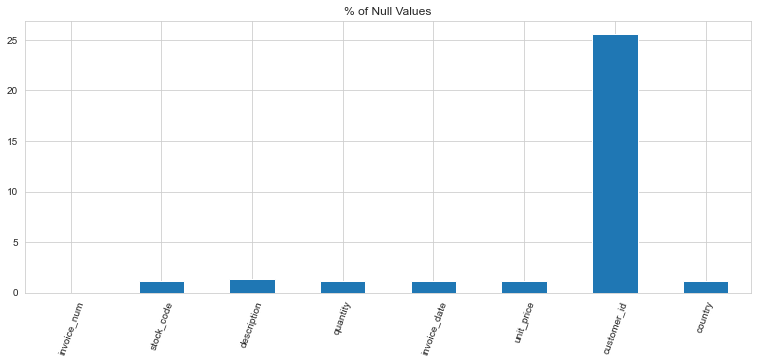

In [12]:
fig,ax = plt.subplots( figsize=(13,5))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax,rot= 70)
ax.set_title('% of Null Values')
plt.show()

In [13]:
# Drop the missing values 

df.dropna(inplace=True)

print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


In [14]:
#Double check it, just in case

df.isnull().sum()

invoice_num     0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [15]:
duplicates_rows = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows are' , duplicates_rows)

The total amount of duplicates rows are 5179


In [16]:
# View the duplicate rows 
# For example rows 598, 601, 604

df[df.duplicated()].head(20)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1.0,12/1/2010 11:49,2.95,17920,United Kingdom
587,536412,22273,FELTCRAFT DOLL MOLLY,1.0,12/1/2010 11:49,2.95,17920,United Kingdom
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1.0,12/1/2010 11:49,3.75,17920,United Kingdom
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1.0,12/1/2010 11:49,2.10,17920,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920,United Kingdom
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2.0,12/1/2010 11:49,3.75,17920,United Kingdom


In [17]:
# Deal with the duplicates 

#df.drop_duplicates(inplace = True, keep = 'first')

In [18]:
# If you check the firest shape we had many duplicates 
# First we had 541909 and now 398003

df.drop_duplicates(inplace = True, keep = 'first')
df.shape

(398003, 8)

In [19]:
duplicate_rows_new = df[df.duplicated()].value_counts().sum()
print('The total amount of duplicates rows after the cleaning are' , duplicate_rows_new)

The total amount of duplicates rows after the cleaning are 0


## Time

In [20]:
# Change the format of the invoice_date 

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: invoice_date, dtype: datetime64[ns]

In [21]:
print("The datafile starts with timepoint {} \n".format(df['invoice_date'].min()))


print("The datafile ends with timepoint {}".format((df['invoice_date'].max())))

The datafile starts with timepoint 2010-12-01 08:26:00 

The datafile ends with timepoint 2011-12-09 12:50:00


In [22]:
last_date = df['invoice_date'].min()
present_date = df['invoice_date'].max()
present_date

Timestamp('2011-12-09 12:50:00')

In [23]:
# Because of the dt.strftime and the to_datetime the type of the invoice_date changed twiced and here i make sure it's the right one

df.dtypes

invoice_num             object
stock_code              object
description             object
quantity               float64
invoice_date    datetime64[ns]
unit_price             float64
customer_id             object
country                 object
dtype: object

# Explore the data 

### Countries

In [24]:
# If you are worry about the last country, it's just the Republic of South Africa (RSA) and EIRE is just the Republic of Ireland

print('Below are the unique name of the countries: \n')

i = 0 
for country_name in df['country'].unique() :
    
    i += 1
    print(f'{i}.', country_name)

Below are the unique name of the countries: 

1. United Kingdom
2. France
3. Australia
4. Netherlands
5. Germany
6. Norway
7. EIRE
8. Switzerland
9. Spain
10. Poland
11. Portugal
12. Italy
13. Belgium
14. Lithuania
15. Japan
16. Iceland
17. Channel Islands
18. Denmark
19. Cyprus
20. Sweden
21. Austria
22. Israel
23. Finland
24. Greece
25. Singapore
26. Lebanon
27. United Arab Emirates
28. Saudi Arabia
29. Czech Republic
30. Canada
31. Unspecified
32. Brazil
33. USA
34. European Community
35. Bahrain
36. Malta
37. RSA


In [25]:
print('In general the total numbers of the countries are:' , i)

In general the total numbers of the countries are: 37


In [26]:
country_df = df[['country' , 'customer_id']]
country_df.groupby(['country']).agg({'customer_id' : 'count'}).sort_values('customer_id', ascending = False).reset_index()

,country,customer_id
0,United Kingdom,353400
1,Germany,9433
2,France,8443
3,EIRE,7419
4,Spain,2508
5,Netherlands,2355
6,Belgium,2060
7,Switzerland,1866
8,Portugal,1466
9,Australia,1250


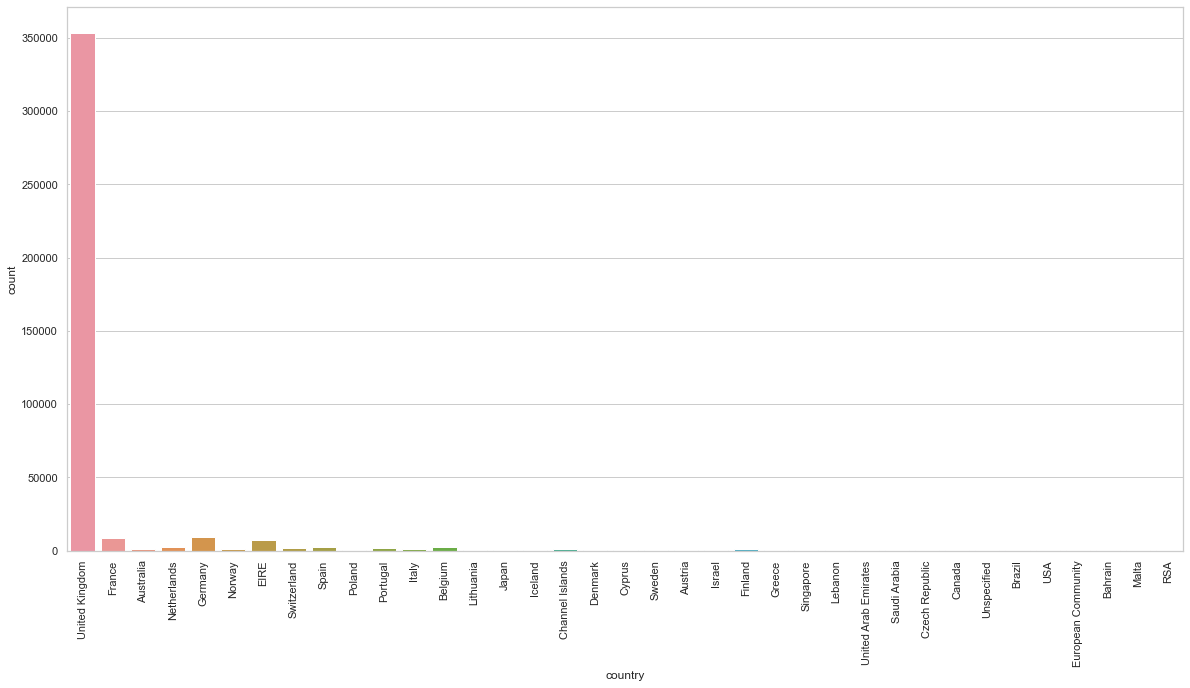

In [27]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(20, 10))

#plot count of each RFM segment
sns.countplot(x="country", data=country_df)
plt.xticks(rotation=90)

plt.show()

In [28]:
# Now we will look at the details of the countries through which most of the orders were placed

df[['invoice_num','country']].groupby('country').count().sort_values("invoice_num",ascending = False).reset_index()

,country,invoice_num
0,United Kingdom,353400
1,Germany,9433
2,France,8443
3,EIRE,7419
4,Spain,2508
5,Netherlands,2355
6,Belgium,2060
7,Switzerland,1866
8,Portugal,1466
9,Australia,1250


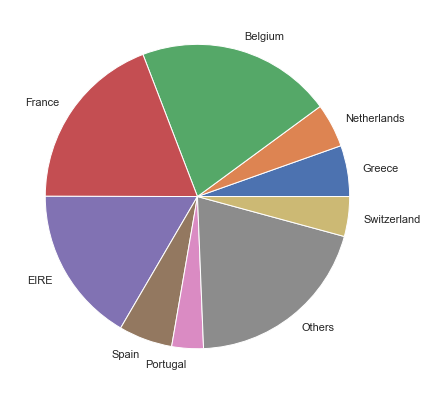

In [33]:
# Creating a Pie Chart to Visualize the the data better

  
# Creating dataset 
country = ['Greece','Netherlands', 'Belgium', 'France' , 'EIRE', 'Spain' , 'Portugal', 'Others','Switzerland']
invoice = [2363,2031,9042,8342,7238,2485 ,1462,8774,1842]
# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(invoice, labels = country) 
  
# show plot 
plt.show() 

In [ ]:
df.describe().round(2)

In [ ]:
# How many unique product are there?

for col in df.columns:
    print(f'{col}: {df[col].nunique()} items')

In [ ]:
# How many of each product are there?

df['stock_code'].value_counts().head(10)

In [ ]:
# Sort the 5 most ordered products from most to least.

print('The most wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).head(20).astype(int)

In [ ]:
# Sort the 5 not most ordered products from most to least.

print('The most not wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).tail(20).astype(int)

In [ ]:
# But what kinf of products are these ? 

print('Below are the top five items we have: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=False)
most_stock_item.head()

In [ ]:
# But what kinf of products are these ? 

print('Below are the last five items we have: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=True)
most_stock_item.head()

## Stock code 

In [ ]:
# View all the stock code of the dataset 

list_special_codes = df[df['stock_code'].str.contains('^[a-zA-Z]+', regex=True)]['stock_code'].unique()
list_special_codes

In [ ]:
for code in list_special_codes:
    print("{:<15} ->  {:<30}".format(code, df[df['stock_code'] == code]['description'].unique()[0]))

### Cancelled Orders & Quantity

In [ ]:
# The number of canceled orders 
# In the data description we can find that a cancelled transactions starts with a "C" in front of it. 
# Let's create a feature to easily filter out these cases:

canceled = (df["invoice_num"].str.contains("C", na=False)).sum()

print('The total number of items that was canceled are', canceled)

In [ ]:
per_canceled = ((canceled / df.shape[0]) * 100 ).round(2)

print('The percentage of canceled orders is ',per_canceled , '%')

In [ ]:
# I am checking if there is negative quantity in tha data 
# Unluckily we have at least one 

flag = False
if (df['quantity'] < 0).any(): 
    flag = True
    print(flag)

In [ ]:
df['canceled'] = df['invoice_num'].apply(lambda x : 'Yes' if x[0] == 'C' else 'No')

In [ ]:
# There is negative quantity in the dataset. Let's check it
# Obviously there are negative quantity 

negative_quantity = df[df['quantity'] < 0]
negative_quantity.head()

In [ ]:
print('The total number of items that was canceled are',negative_quantity.value_counts().sum() ) 

[Link](https://stackoverflow.com/questions/24214941/python-pandas-dataframe-filter-negative-values)

In [ ]:
# I just drop the rows with the negative quantity 
# To use and statements inside a data-frame you just have to use a single & character 
# and separate each condition with parenthesis. (Link above in Stackoverflow)

df = df[df['quantity'] > 0]
df.head()

In [ ]:
# The shape of our dataset just got even smaller after the drop 

df.shape

## Calculation of RFM metrics

* Recency : the number of days between today_date and the last purchase date of this customer

* Frequency : the number of purchase of this customer

* Monetary : sum of TotalPrice of this customer

In [ ]:
# I create a new column here 

df["total_price"] = df["quantity"] * df["unit_price"]

In [ ]:
df.sort_values('total_price', ascending=False).head().reset_index()

In [ ]:
#No. of products sold by Country

products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).head(10)
products_country

In [ ]:
#No. of products sold by Country

products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).tail(10)
products_country

In [ ]:
present = dt.date(2011,12,9)

#### Create the RFM Table

In [ ]:
#new_df = df[['quantity' , 'unit_price', 'total_price']]
#new_df.head()

In [ ]:
# Aggregate at customer level
#customer_df = pd.DataFrame(df.pivot_table(index="customer_id", 
                                            
                                              #values=["invoice_date", "total_price"], 
                                            
                                              #aggfunc={"invoice_date": [min, max, pd.Series.nunique], "total_price": sum}))
#customer_df.head()

In [ ]:
#customer_df.columns = ["LastInvoiceDate", "FirstInvoiceDate", "Frequency", "MonetaryValue"]
#customer_df.head().reset_index()

In [ ]:
today_date = dt.datetime(2011,12,11)

In [ ]:
rfm = df.groupby('customer_id').agg({'invoice_date' : lambda invoice_date:  (today_date - invoice_date.max()).days,
                                    'invoice_num'   : lambda invoice_num:   invoice_num.nunique(),
                                    'total_price'   : lambda total_price:   total_price.sum()})

In [ ]:
rfm.columns = ['recency','frequency','monetary']
rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

In [ ]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(13, 7))

rfm.boxplot(grid=False, rot=45, fontsize=15)

In [ ]:
# Fing top 10 customers based on frequency and monetary values
# Sorting first on frequency and then on Monetary value¶
# Below are top ten customers after sorting¶

rfm.sort_values(['frequency', 'monetary'], ascending=[False, False], inplace=True)
rfm.head()

### RFM Scores

In [ ]:
# i use the method qcut, in order to cut the three columns in five quartiles. 
# I could do it by hand by i didn't really like especially pandas has it arleady 

rfm['recency_score'] = pd.qcut(rfm['recency'] , 5 , labels = range(1,6,1))

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels =range(1, 6, 1) )

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels= range(1, 6, 1))

rfm['RFM_Score'] = rfm[['recency_score', 'frequency_score', 'monetary_score']].sum(axis=1).astype(int)

rfm['RFM_Segmentantion'] = (rfm['recency_score'].astype(str) 
                            + rfm['frequency_score'].astype(str) 
                            + rfm['monetary_score'].astype(str))

In [ ]:
rfm.head()

In [ ]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(20, 5))

#plot count of each RFM segment
sns.countplot(x="RFM_Segmentantion", data=rfm)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Create a new column accordingly to the customers score 

def rank(a):
    
    if  (a >= 0) & (a <= 3):
        return 'Basic'
    
    elif (a <=7):
        return 'Advanced'
    
    elif (a <= 13):
        return 'Gold'
    else:
        return 'Platinum'

In [ ]:
rfm['Rank_id'] = rfm['RFM_Score'].apply(rank)
rfm.head(10).reset_index()

In [ ]:
# VIZOUALAZATION ANALOGA TON RANK TOUS EDW 

In [ ]:
# We can underastand better the clients by the rank 

ranks = rfm['Rank_id'].value_counts()
ranks

In [ ]:
end = time.time()
time = end - start 
time1 = round(time, 2)
print('The project executed only in', time1 , 'seconds')